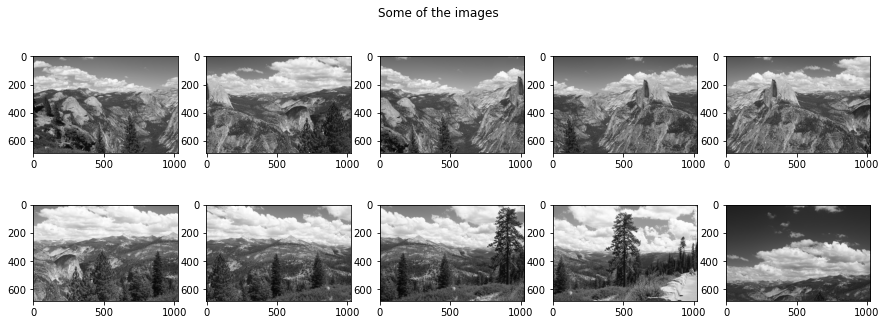

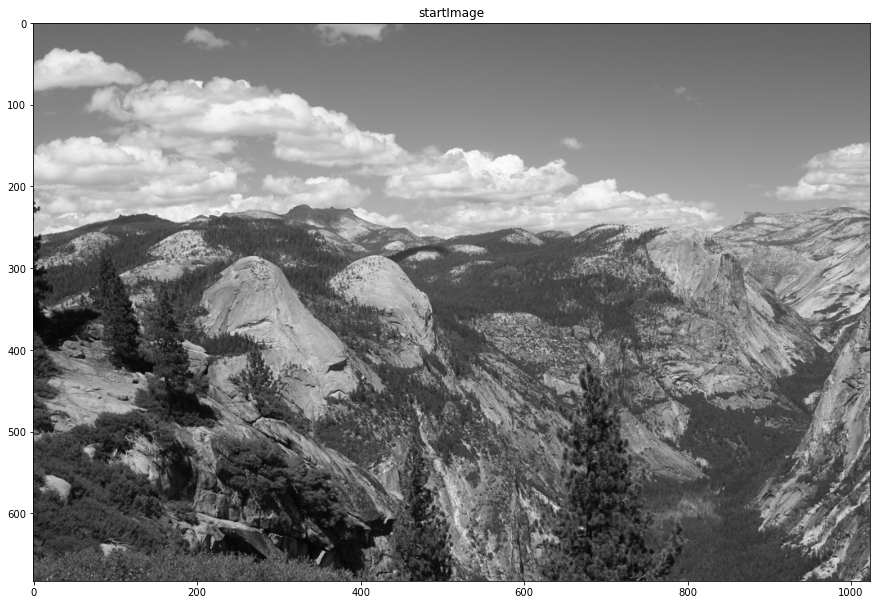

In [13]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import cv2
import os
import math
import numpy as np 


# relativePathFolder = 'images/arena/source_images/'
# relativePathFolder = 'images/big_house/source_images/'
# relativePathFolder = 'images/carmel/source_images/'
relativePathFolder = 'images/halfdome/source_images/'

images = []
for filename in os.listdir(relativePathFolder):
    img = cv2.imread(os.path.join(relativePathFolder, filename))
    if img is not None:
        images.append(img)

if len(images) < 5:
    fig, ax = plt.subplots(1, len(images), figsize=(15, 12))
    for j in range(len(images)):
        ax[j].imshow(images[j])           
else:
    fig, ax = plt.subplots(math.floor(len(images)/5), 5, figsize=(15, 5))
    fig.suptitle('Some of the images')

    k = 0
    for i in range(math.floor(len(images)/5)):
        for j in range(5):
            ax[i,j].imshow(images[k])
            k+=1
                           
                
#AUMENTING startImage WITH BLACK BORDERS
startImgIndex = 0

startImage = images[startImgIndex]

plt.figure(figsize=(15,12))
plt.imshow(startImage)
plt.title('startImage')
plt.show()

dimenticaXk = images.pop(startImgIndex)


In [ ]:
# EXTRACTING FEATURES

# Get gray images
images_g = []
for i in range(len(images)):
    images_g.append(cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY))

#sift 
sift = cv2.xfeatures2d.SIFT_create()

# compute keypoints and descriptors of all images except baseImage
keypoints = []
descriptors = []
for i in range(len(images)):
    kp, descr = sift.detectAndCompute(images_g[i],None)
    keypoints.append(kp)
    descriptors.append(descr)


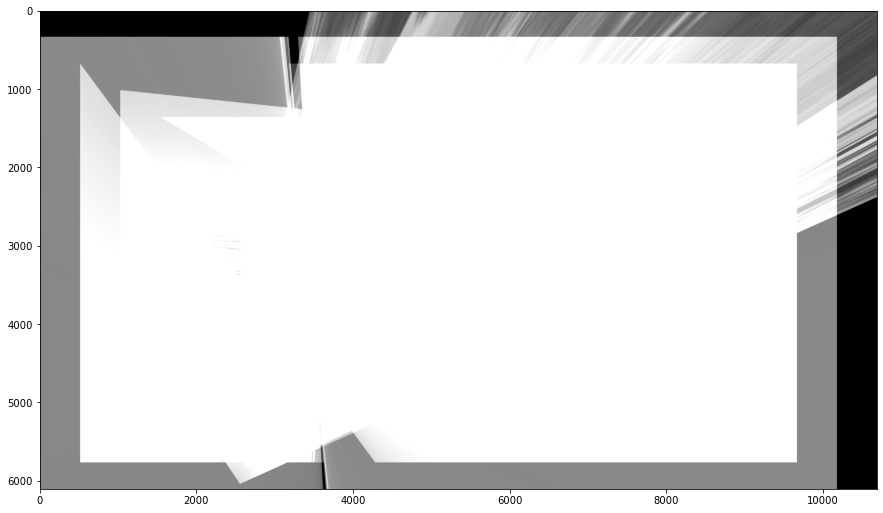

In [127]:
# trim image function 
def trim_black_countour(image): 
    mask = np.argwhere(image != 0)

    min_x = np.min(mask[:,1])
    max_x = np.max(mask[:,1])

    min_y = np.min(mask[:,0])
    max_y = np.max(mask[:,0])

    return image[min_y:max_y, min_x:max_x,:]

base_img = startImage
    
# brute force matching, takes the descriptor of one feature i#  first set and this is matched with
# all other features in second set using some distance calculation. The closest one is returned.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

alreadyUsedImagesIdxs = []

for i in range(len(images)):
    # Augment base image with black countour, assuming images shape all equal to the one of startImage
    top = int(startImage.shape[0]/2)
    bottom = top
    right = int(startImage.shape[1]/2)
    left = right

    base_img = cv2.copyMakeBorder(base_img, top, bottom, left, right, cv2.BORDER_CONSTANT, None, 0)

    base_img_g = cv2.cvtColor(base_img, cv2.COLOR_BGR2GRAY)

    base_kp, base_descr = sift.detectAndCompute(base_img_g, None)
    numberOfMatchesOfMatches = 0
    bestMatches = []
    
    for j in range(len(images)):
        if j not in alreadyUsedImagesIdxs:
            matches = bf.match(base_descr, descriptors[j])
            if len(matches) > numberOfMatchesOfMatches:
                numberOfMatches = len(matches)
                bestMatches = matches
                bestMatchIdx = j
                
    alreadyUsedImagesIdxs.append(bestMatchIdx)
    bestMatches = sorted(bestMatches, key = lambda x:x.distance)
    bestMatchesKeyPoints = keypoints[bestMatchIdx]
    
    # Homography computation
    
    numberOfPoints = 10
    
    # vector initialization
    baseImage_idx = bestMatches[0].queryIdx
    bestMatch_idx = bestMatches[0].trainIdx
    
    pts_base = np.array([[0, 0]])
    pts_bestMatch = np.array([[0, 0]])

    for x in range(numberOfPoints):
        baseImage_idx = bestMatches[x].queryIdx
        best_idx = bestMatches[x].trainIdx
        
        pts_base = np.concatenate((pts_base, [[base_kp[baseImage_idx].pt[0], base_kp[baseImage_idx].pt[1]]]))
        pts_bestMatch = np.concatenate((pts_bestMatch, [[bestMatchesKeyPoints[best_idx].pt[0], bestMatchesKeyPoints[best_idx].pt[1]]]))
        
    h, status = cv2.findHomography(pts_bestMatch, pts_base, cv2.RANSAC, 10.0)
    
    # Warped image
    img_warped = cv2.warpPerspective(images[bestMatchIdx], h, (base_img.shape[1], base_img.shape[0]))

    # Mosaice with the other image
    base_img = cv2.add(base_img, img_warped)
    base_img = trim_black_countour(base_img)
    
out_img = base_img
plt.figure(figsize=(15,12))
plt.imshow(out_img)
plt.show()

In [ ]:
# Access coordinates on conjugate points

idx_query = matches[0].queryIdx
idx_train = matches[0].trainIdx

x_1 = int(keypoints_1[idx_query].pt[0])
y_1 = int(keypoints_1[idx_query].pt[1])

x_2 = int(keypoints_2[idx_train].pt[0])
y_2 = int(keypoints_2[idx_train].pt[1])

# image1 = cv2.circle(img1, (x_1, y_1), radius=7, color=(0, 0, 255), thickness=-1)

# image2 = cv2.circle(img2, (x_2, y_2), radius=7, color=(0, 0, 255), thickness=-1)

fig, ax = plt.subplots(1, 2, figsize=(15, 12))

ax[0].imshow(image1)
ax[0].axis('off')  
# ax[1].set_title('1')
ax[1].imshow(image2)
ax[1].axis('off')  
# ax[1].set_title('2')


In [ ]:
# Draw some matches with automatic drawMatches function
img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:0], img2, flags=2)

plt.figure(figsize=(15,12))
plt.imshow(img3),
plt.show()

In [ ]:
# Homography computation
import numpy as np 
idx_query = matches[0].queryIdx
idx_train = matches[0].trainIdx

pts_1 = np.array([[keypoints_1[idx_query].pt[0], keypoints_1[idx_query].pt[1]]])
pts_2 = np.array([[keypoints_2[idx_train].pt[0], keypoints_2[idx_train].pt[1]]])

numberOfPoints = 10
for x in range(numberOfPoints):
    idx_query = matches[x].queryIdx
    idx_train = matches[x].trainIdx
    
    pts_1 = np.concatenate((pts_1, [[keypoints_1[idx_query].pt[0], keypoints_1[idx_query].pt[1]]]))
    pts_2 = np.concatenate((pts_2, [[keypoints_2[idx_train].pt[0], keypoints_2[idx_train].pt[1]]]))

h, status = cv2.findHomography(pts_1, pts_2, cv2.RANSAC, 10.0)


In [ ]:
# Warped image
img_warped = cv2.warpPerspective(img1, h, (img1.shape[1],img1.shape[0]))

plt.figure(figsize=(15,12))
plt.imshow(img_warped),
plt.show()


In [ ]:
# Mosaice with the other image
img_out = cv2.add(img2, img_warped)

plt.figure(figsize=(15,12))
plt.imshow(img_out),
plt.show()